In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# === Transform ===
transform = transforms.Compose([
    transforms.Resize((32,32)),#resizes all images to 32x32
    transforms.ToTensor(),#converts the image to PyTorch tensor        
    transforms.Normalize((0.5,), (0.5,)) #mean 0.5, standard deviation 0.5
])



In [3]:
from PIL import Image
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data['label'].values
        self.images = self.data.drop('label', axis=1).values.reshape(-1,28,28).astype('uint8')  # PIL için uint8
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)  # NumPy -> PIL Image
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
# === CSV File Path ===
train_csv = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
test_csv  = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

In [5]:
# === Dataset ve DataLoader ===
train_data = FashionMNISTDataset(train_csv, transform=transform)
test_data  = FashionMNISTDataset(test_csv, transform=transform)

In [6]:
# Train/Validation split
train_ds, val_ds = random_split(train_data, [50000, 10000])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

In [7]:
# === Data Augmentation ===
aug_transform = transforms.Compose([
    transforms.RandomRotation(10),#randomly rotate the image between -10 and +10 degrees
    transforms.RandomHorizontalFlip(),#randomly flip image horizontally
    transforms.Resize((32,32)),#resize
    transforms.ToTensor(),#convert image to PyTorch tensor format
    transforms.Normalize((0.5,), (0.5,))# normalize tensor values to the range [-1,1]
])
train_data.transform = aug_transform

In [8]:
# === CNN Model ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),# 1 grayscale, 32 filtre, 3x3 kernel
            nn.ReLU(),#activation function
            nn.MaxPool2d(2),#size reduction with 2x2 
            nn.Conv2d(32, 64, 3, padding=1),#32 input filters, 64 output filters
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),# Convert 2D feature map to 1D vector
            nn.Linear(64*8*8, 128),#dense layer: 64 filters * 8x8 size -> 128 neurons
            nn.ReLU(),
            nn.Dropout(0.5),#dropout to reduce overfitting
            nn.Linear(128, 10)  #output layer: for 10 classes
        )
    def forward(self, x):
        return self.fc(self.conv(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [9]:
# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
# Adam optimizer: Updates model parameters with an adaptive learning rate
# lr=1e-3: The learning rate determines how quickly the parameters are updated
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# === Training Loop with Early Stopping & Checkpoint ===
#set training parameters
epochs = 20          #total number of training epochs
patience = 3         #early stopping patience
best_val_loss = np.inf  #initialize best validation loss as infinity
best_model_wts = copy.deepcopy(model.state_dict())  #store best model weights

#lists to store training/validation losses and accuracies
train_losses, val_losses = [], []
train_accs, val_accs = [], []
counter = 0  #counter for early stopping

for epoch in range(epochs):
    # --- Training phase ---
    model.train()  #set model to training mode
    running_loss, running_correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  #move data to device
        optimizer.zero_grad()          #clear gradients
        outputs = model(images)        #forward pass
        loss = criterion(outputs, labels)  #compute loss
        loss.backward()                #backward pass
        optimizer.step()               #update parameters

        # Update running loss and correct predictions
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = running_correct / total

    # --- Validation phase ---
    model.eval()  #set model to evaluation mode
    val_running_loss, val_running_correct, val_total = 0.0, 0, 0
    with torch.no_grad():  #no gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / val_total
    val_acc = val_running_correct / val_total

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # --- Early Stopping & Checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())  #save best weights
        torch.save(model.state_dict(), "best_model.pth")    #save checkpoint
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("⏹️ Early stopping!")  #stop training if no improvement
            break

# === Load Best Model ===
# Load the model weights with the lowest validation loss
model.load_state_dict(best_model_wts)


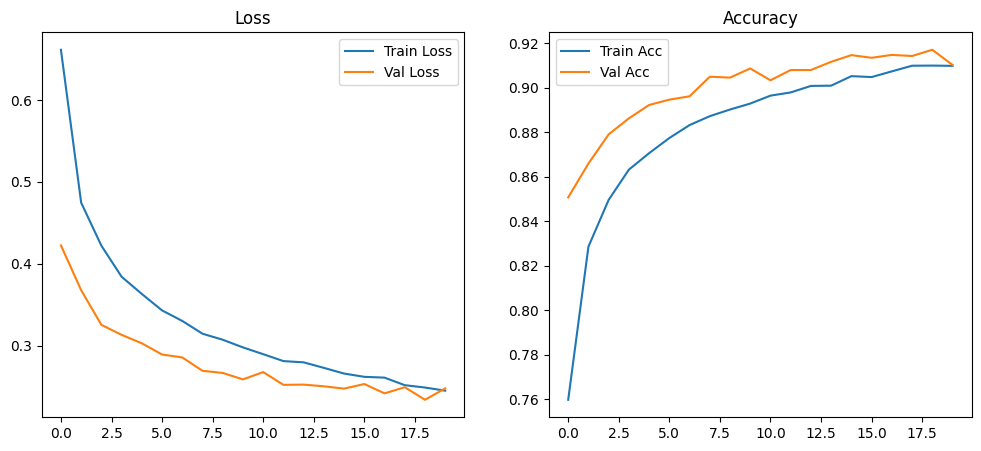

In [11]:
# === Loss & Accuracy Plots ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss")
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy")
plt.show()



In [12]:
# === Test Evaluation ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [13]:
# Test Accuracy
test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Test Accuracy: {test_acc:.4f}")



✅ Test Accuracy: 0.9245


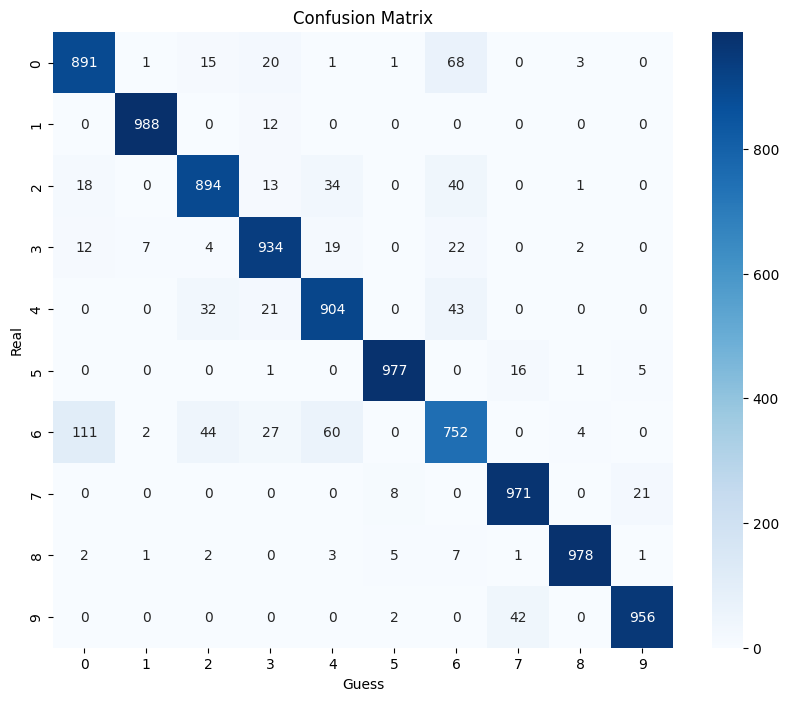

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.89      0.90      1000
           3       0.91      0.93      0.92      1000
           4       0.89      0.90      0.89      1000
           5       0.98      0.98      0.98      1000
           6       0.81      0.75      0.78      1000
           7       0.94      0.97      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [14]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Guess")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))